![title](gen.jpg)

# Genpact Machine Learning Hackathon - Kaggle 

Genpact and Analytics Vidhya presents the “Genpact Machine Learning Hackathon 2018”. A great opportunity to showcase your machine learning and analytical abilities and compete with the best data scientists out there.


## Problem Statement
Your client is a meal delivery company which operates in multiple cities. They have various fulfillment centers in these cities for dispatching meal orders to their customers. The client wants you to help these centers with demand forecasting for upcoming weeks so that these centers will plan the stock of raw materials accordingly.

The replenishment of majority of raw materials is done on weekly basis and since the raw material is perishable, the procurement planning is of utmost importance. Sec
ondly, staffing of the centers is also one area wherein accurate demand forecasts are really helpful. Given the following information, the task is to predict the demand for the next 10 weeks (Weeks: 146-155) for the center-meal combinations in the test set:
 

* Historical data of demand for a product-center combination (Weeks: 1 to 145)
* Product(Meal) features such as category, sub-category, current price and discount
* Information for fulfillment center like center area, city information etc.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 8
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Any results you write to the current directory are saved as output.

['fulfilment_center_info.csv', 'meal_info.csv', 'train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
meal=pd.read_csv('meal_info.csv')
ful=pd.read_csv('fulfilment_center_info.csv')
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [3]:
meal['combo']=meal['category']+" "+meal['cuisine']
meal.head()

,meal_id,category,cuisine,combo
0,1885,Beverages,Thai,Beverages Thai
1,1993,Beverages,Thai,Beverages Thai
2,2539,Beverages,Thai,Beverages Thai
3,1248,Beverages,Indian,Beverages Indian
4,2631,Beverages,Indian,Beverages Indian


In [4]:
df=train.merge(meal,on=['meal_id'],how='left')
df=df.merge(ful,on=['center_id'],how='left')

In [5]:
df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,combo,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,Beverages Thai,647,56,TYPE_C,2.0
1,1466964,1,55,1993,136.83,135.83,0,0,270,Beverages,Thai,Beverages Thai,647,56,TYPE_C,2.0
2,1346989,1,55,2539,134.86,135.86,0,0,189,Beverages,Thai,Beverages Thai,647,56,TYPE_C,2.0
3,1338232,1,55,2139,339.50,437.53,0,0,54,Beverages,Indian,Beverages Indian,647,56,TYPE_C,2.0
4,1448490,1,55,2631,243.50,242.50,0,0,40,Beverages,Indian,Beverages Indian,647,56,TYPE_C,2.0


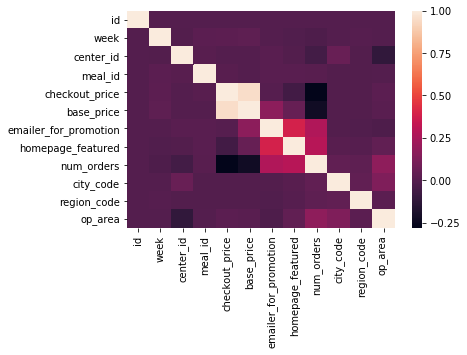

In [6]:
import seaborn as sns
sns.heatmap(df.corr())

In [7]:
df.info()
df_m=df.copy()
df['region_code']=df['region_code'].astype(np.object)
df=pd.get_dummies(df,drop_first=True)
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456548 entries, 0 to 456547
Data columns (total 16 columns):
id                       456548 non-null int64
week                     456548 non-null int64
center_id                456548 non-null int64
meal_id                  456548 non-null int64
checkout_price           456548 non-null float64
base_price               456548 non-null float64
emailer_for_promotion    456548 non-null int64
homepage_featured        456548 non-null int64
num_orders               456548 non-null int64
category                 456548 non-null object
cuisine                  456548 non-null object
combo                    456548 non-null object
city_code                456548 non-null int64
region_code              456548 non-null int64
center_type              456548 non-null object
op_area                  456548 non-null float64
dtypes: float64(3), int64(9), object(4)
memory usage: 59.2+ MB


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,op_area,category_Biryani,category_Desert,category_Extras,category_Fish,category_Other Snacks,category_Pasta,category_Pizza,category_Rice Bowl,category_Salad,category_Sandwich,category_Seafood,category_Soup,category_Starters,cuisine_Indian,cuisine_Italian,cuisine_Thai,combo_Beverages Indian,combo_Beverages Italian,combo_Beverages Thai,combo_Biryani Indian,combo_Desert Indian,combo_Extras Thai,combo_Fish Continental,combo_Other Snacks Thai,combo_Pasta Italian,combo_Pizza Continental,combo_Rice Bowl Indian,combo_Salad Italian,combo_Sandwich Italian,combo_Seafood Continental,combo_Soup Thai,combo_Starters Thai,region_code_34,region_code_35,region_code_56,region_code_71,region_code_77,region_code_85,region_code_93,center_type_TYPE_B,center_type_TYPE_C
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [8]:
df['discount']=df['base_price']-df['checkout_price']
df['discount_per']=(df['discount']/df['base_price'])*100
df['op_dis']=df['discount_per']*df['op_area']
df['promo_homepage']=df['emailer_for_promotion']+df['homepage_featured']
df['week']=df['week'].astype(np.object)
df['center_id']=df['center_id'].astype(np.object)
df['meal_id']=df['meal_id'].astype(np.object)
df['city_code']=df['city_code'].astype(np.object)


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456548 entries, 0 to 456547
Data columns (total 56 columns):
id                           456548 non-null int64
week                         456548 non-null object
center_id                    456548 non-null object
meal_id                      456548 non-null object
checkout_price               456548 non-null float64
base_price                   456548 non-null float64
emailer_for_promotion        456548 non-null int64
homepage_featured            456548 non-null int64
num_orders                   456548 non-null int64
city_code                    456548 non-null object
op_area                      456548 non-null float64
category_Biryani             456548 non-null uint8
category_Desert              456548 non-null uint8
category_Extras              456548 non-null uint8
category_Fish                456548 non-null uint8
category_Other Snacks        456548 non-null uint8
category_Pasta               456548 non-null uint8
category_Piz

## Catboost

In [10]:
from catboost import CatBoostClassifier,Pool, cv,CatBoostRegressor
from sklearn.model_selection import StratifiedKFold,train_test_split


X,y=df.drop(['id','num_orders'],axis=1),df.num_orders
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.25,random_state = 1994)

categorical_features_indices = np.where(X_train.dtypes =='object')[0]

In [11]:
cat_model = CatBoostRegressor(n_estimators=1000, # use large n_estimators deliberately to make use of the early stopping
                         reg_lambda=1.0,
#                          l2_leaf_reg=4.0,
                         eval_metric='MSLE',
                         random_seed=1994,
                         learning_rate = 0.03,
                         depth = 11,
                               
#                                boosting_type = 'Ordered',
#                          subsample = 0.8
                         #rsm = 0.7,
                         #silent=True,
                         #max_ctr_complexity = 5,  # no of categorical cols combined
#                          boosting_type = 'Ordered',
#                          od_type = 'IncToDec',  #overfitting params
#                          od_wait = 20)
                         bagging_temperature = 1.0)
                              
# lr=0.05, no od type of vars -- highest
    
cat_model.fit(X_train.values,y_train.values,cat_features=categorical_features_indices,
              eval_set=(X_val, y_val),plot=False,early_stopping_rounds=100,use_best_model=True,verbose_eval=50)

0:	learn: 15.2333177	test: 15.1822811	best: 15.1822811 (0)	total: 876ms	remaining: 14m 35s
50:	learn: 0.8474826	test: 0.8409674	best: 0.8409674 (50)	total: 32.8s	remaining: 10m 10s
100:	learn: 0.4557997	test: 0.4539665	best: 0.4539665 (100)	total: 1m 5s	remaining: 9m 42s
150:	learn: 0.4025927	test: 0.4025463	best: 0.4025463 (150)	total: 1m 38s	remaining: 9m 13s
200:	learn: 0.3792391	test: 0.3796165	best: 0.3796165 (200)	total: 2m 13s	remaining: 8m 50s
250:	learn: 0.3634313	test: 0.3621679	best: 0.3621679 (250)	total: 2m 50s	remaining: 8m 27s
300:	learn: 0.3534466	test: 0.3506433	best: 0.3506433 (300)	total: 3m 27s	remaining: 8m 2s
350:	learn: 0.3453123	test: 0.3415151	best: 0.3415151 (350)	total: 4m 5s	remaining: 7m 33s
400:	learn: 0.3387812	test: 0.3344768	best: 0.3344492 (399)	total: 4m 44s	remaining: 7m 5s
450:	learn: 0.3318970	test: 0.3271755	best: 0.3271389 (448)	total: 5m 24s	remaining: 6m 34s
500:	learn: 0.3258101	test: 0.3206337	best: 0.3206337 (500)	total: 6m 4s	remaining: 6m 

In [12]:
sorted(zip(cat_model.feature_importances_,X_train),reverse=True)

[(26.32956521957252, 'meal_id'),
 (15.330103186691355, 'center_id'),
 (11.755278612856518, 'promo_homepage'),
 (7.234557699542892, 'checkout_price'),
 (5.296932325450034, 'discount_per'),
 (4.873312938248468, 'city_code'),
 (4.210236592459667, 'op_dis'),
 (3.773340760723439, 'week'),
 (3.4936442828948318, 'base_price'),
 (2.324342692618065, 'cuisine_Italian'),
 (2.2984302205174316, 'cuisine_Indian'),
 (2.240749916593389, 'op_area'),
 (1.7128501654027868, 'emailer_for_promotion'),
 (1.526839392419421, 'center_type_TYPE_B'),
 (1.263678706755763, 'center_type_TYPE_C'),
 (0.9078731635399888, 'category_Sandwich'),
 (0.846272528748631, 'discount'),
 (0.7877307181512092, 'combo_Sandwich Italian'),
 (0.7552054592449189, 'homepage_featured'),
 (0.5102564730184909, 'region_code_93'),
 (0.487441966055904, 'region_code_85'),
 (0.3608148406943788, 'region_code_71'),
 (0.34051762293745064, 'region_code_56'),
 (0.3263686310679704, 'combo_Rice Bowl Indian'),
 (0.32449689706260454, 'category_Rice Bowl'

In [28]:
def pos(val):
    r=[]
    for i in val:
        if i<0:
            r.append(0)
        else:
            r.append(i)
    return r

In [29]:
from sklearn.metrics import mean_squared_log_error
preds = cat_model.predict(X_val)
print(100*np.sqrt(mean_squared_log_error(y_val,pos(preds))))

53.7763902461187


In [24]:
sum(preds<0)

1

In [ ]:
dftest=test.merge(meal,on=['meal_id'],how='left')
dftest=dftest.merge(ful,on=['center_id'],how='left')

dftest['region_code']=dftest['region_code'].astype(np.object)
dftest=pd.get_dummies(dftest,drop_first=True)
dftest['discount']=dftest['base_price']-dftest['checkout_price']
dftest['discount_per']=(dftest['discount']/dftest['base_price'])*100
dftest['op_dis']=dftest['discount_per']*df['op_area']
dftest['promo_homepage']=dftest['emailer_for_promotion']+df['homepage_featured']
dftest['week']=dftest['week'].astype(np.object)
dftest['center_id']=dftest['center_id'].astype(np.object)
dftest['meal_id']=dftest['meal_id'].astype(np.object)
dftest['city_code']=dftest['city_code'].astype(np.object)
dftest.shape
# dftest['region_code']=dftest['region_code'].astype(np.object)

In [ ]:
dftest.head()

In [ ]:
err=[]
y_pred_tot=[]
from sklearn.model_selection import KFold,StratifiedKFold
fold=StratifiedKFold(n_splits=5,shuffle=True,random_state=1994)
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print('start')
    cat_model5 = CatBoostRegressor(n_estimators=1000, # use large n_estimators deliberately to make use of the early stopping
                         reg_lambda=1.0,
                         eval_metric='MSLE',
                         random_seed=1994,
                         learning_rate = 0.03,
                         depth = 11,
                         bagging_temperature = 1.0)
    cat_model5.fit(X_train.values,y_train.values,cat_features=categorical_features_indices,eval_set=(X_test, y_test),
        plot=False,early_stopping_rounds=100,use_best_model=True,verbose_eval=50) # early stopping set to 100 to prevent overfitting
    print('pred...')
    p = cat_model5.predict(X_test)
    if sum(p<0)>0:
        p=pos(p)
    print("err: ",100*np.sqrt(mean_squared_log_error(y_test,p)))
    err.append(100*np.sqrt(mean_squared_log_error(y_test,p)))
    pred = cat_model5.predict(dftest.drop('id',axis=1))
    y_pred_tot.append(pred)

In [ ]:
# y_pred=rf.predict(dftest_dum.drop('id',axis=1))
print(np.mean(err,0))
y_pred=np.mean(y_pred_tot,0)

In [ ]:
s=pd.DataFrame({'id':test.id,'num_orders':y_pred})
s.to_csv('stackedCBfold5.csv',index=False)
s.head()